In [103]:
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))
from scipy.io import loadmat
from pathlib import Path
import matplotlib.patches as patches
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
# the following import is required for matplotlib < 3.2:
from mpl_toolkits.mplot3d import Axes3D  # noqa
from scipy import stats
from scipy.stats import mannwhitneyu, ttest_rel
from scipy.signal import butter, filtfilt
import mne
import eeg_analysis.funcs4eeg as fe
import re
import imp
import ast
import behavior.func4behav as fb
imp.reload(fe)
imp.reload(fb)
import matplotlib

from scipy import signal
from scipy.signal import resample
from scipy.ndimage import zoom

### for endo or exo

In [104]:
def align_slow(eeg, case, fs):
    if 'endo' in case:
        jump_from, jump_to = int((1.5+1+0.5)*fs), int((1.5+1+1)*fs)
    elif 'exo' in case:
        jump_from, jump_to = int((1.5+0.033*4+0.5)*fs), int((1.5+0.033*4+1)*fs)
    
    for channel in range(len(eeg)):
        eeg[channel] = np.concatenate((eeg[channel][:,:jump_from], eeg[channel][:,jump_to:]), axis=1)
        
    return eeg

case_title = 'exo' # switch 'endo' or 'exo' HERE!
case_list = [case_title+' fast', case_title+' slow']
if 'endo' in case_title:
    tmax_list = [1.5+1+0.5+0.05+0.2, 1.5+1+1+0.05+0.2]
else:
    tmax_list = [1.5+0.033*4+0.5+0.05+0.2, 1.5+0.033*4+1+0.05+0.2]

fs = 1200
for i, case in enumerate(case_list):
    tmax = tmax_list[i]
    watch = '1 fixation'
    tmin = 0 # include fix or not?

    highpass = None
    lowpass = None

    sb, sa, rb, ra = fe.pipeline_bpdata_channel(case, watch, tmin, tmax, hipass=highpass, lopass=lowpass, baseline=(0,0), detrend=1)
    
    if 'slow' in case:
        # sham_before_slow = align_slow(sb, case, fs)
        # sham_after_slow = align_slow(sa, case, fs)
        # real_before_slow = align_slow(rb, case, fs)
        # real_after_slow = align_slow(ra, case, fs)

        sham_before_slow = sb
        sham_after_slow = sa
        real_before_slow = rb
        real_after_slow = ra

    else:
        sham_before_fast = sb
        sham_after_fast = sa
        real_before_fast = rb
        real_after_fast = ra

c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavior_compare, new_row], ignore_index=True)
c:\Users\Tianyi Zheng\OneDrive - neuron.t.u-tokyo.ac.jp\Documents\zheng\mywork\attention_tES\tACS-Attention\processing\behavior\func4behav.py:158: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  behavior_compare = pd.concat([behavio

In [105]:
freq_bands = [[4, 8], [8, 12], [12, 30], [30, 46]]
# exclude fixation
endo_fast_interval = [1.5+1, 1.5+1+0.5]
# endo_slow_interval = [1.5+1, 1.5+1+0.5+0.05+0.2]
endo_slow_interval = [1.5+1, 1.5+1+1]
exo_fast_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
# exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+0.5]
exo_slow_interval = [1.5+0.033*4, 1.5+0.033*4+1]

if 'endo' in case_title:
    intervals = [endo_fast_interval, endo_slow_interval]
else:
    intervals = [exo_fast_interval, exo_slow_interval]

origin_slow_sessions = [sham_before_slow, sham_after_slow, real_before_slow, real_after_slow] # 4 sessions * y subjects * (z trials * 32 channels * timepoints)
origin_fast_sessions = [sham_before_fast, sham_after_fast, real_before_fast, real_after_fast]

In [106]:
slow_sessions, fast_sessions = [None]*4, [None]*4
for i, session in enumerate(origin_slow_sessions): # session in shape: y subjects * (z trials * 32 channels * timepoints)
    tmp = session[0] # tmp in shape: z trials * 32 channels * timepoints
    for j in range (1, len(session)):
        tmp = np.concatenate((tmp, session[i])) # session[i] in shape: z trials * 32 channels * timepoints
    slow_sessions[i] = tmp

for i, session in enumerate(origin_fast_sessions):
    tmp = session[0]
    for j in range (1, len(session)):
        tmp = np.concatenate((tmp, session[i]))
    fast_sessions[i] = tmp

# times 1e6
for i in range(4):
    slow_sessions[i] = slow_sessions[i] * 1e6
    fast_sessions[i] = fast_sessions[i] * 1e6

print(slow_sessions[0].shape, slow_sessions[1].shape, slow_sessions[2].shape, slow_sessions[3].shape)
print(fast_sessions[0].shape, fast_sessions[1].shape, fast_sessions[2].shape, fast_sessions[3].shape)
# 2.2s

(189, 32, 3459) (269, 32, 3459) (245, 32, 3459) (231, 32, 3459)
(175, 32, 2859) (268, 32, 2859) (254, 32, 2859) (233, 32, 2859)


In [107]:
bp_data = [np.empty(()),np.empty(()),np.empty(()),np.empty(())] # 4 sessions, xx trials, 32 channels, 4 freq bands
count = 0
for i in range(4):
    fast_session = fast_sessions[i]
    slow_session = slow_sessions[i]
    one_session = np.empty((fast_sessions[i].shape[0]+slow_sessions[i].shape[0],32,4))
    # print(one_session.shape)
    for j, data in enumerate([fast_session, slow_session]): # data: trials x channels x time
        interval = intervals[j]
        t_start, t_end = int(interval[0]*fs), int(interval[1]*fs)
        trial_count = j*fast_session.shape[0]-1
        for trial in range(data.shape[0]):
            trial_count += 1
            one_trial = np.empty((32,4))  
            psds, freqs = mne.time_frequency.psd_array_multitaper(data[trial,:,t_start:t_end], fs, fmin=1, fmax=51, verbose=False)
            # print(psds.max())
            for k, band in enumerate(freq_bands):
                bp = fe.band_power(psds, freqs, band)
                # if bp.min() < 100:
                #     print('session:', i, 'trial:', trial, 'band:', band, 'min:', bp.min())
                #     count += 1
                # if bp.max() > 1e5:
                #     print('session:', i, 'trial:', trial, 'band:', band, 'max:', bp.max())
                #     count += 1
                one_trial[:,k] = bp
            # print(trial_count)
            one_session[trial_count,:,:] = one_trial # one_session[trial_count,:,:] in shape: 32 channels * 4 freq bands
    bp_data[i] = one_session

print(count)
# 6.1s

0


In [108]:
# remove outliers

# # Set the value of k
# k = 1000  # This can be adjusted based on how strict you want the outlier detection to be

# # Function to detect and remove rows with outliers
# def remove_outliers(data, k):
#     # Calculate Q1, Q3, and IQR for each element position in the (32, 4) matrices
#     Q1 = np.percentile(data, 25, axis=0)
#     Q3 = np.percentile(data, 75, axis=0)
#     IQR = Q3 - Q1

#     # Calculate the outlier thresholds
#     lower_bound = Q1 - k * IQR
#     upper_bound = Q3 + k * IQR

#     # Create a mask that identifies rows with any outliers
#     outlier_mask = (data < lower_bound) | (data > upper_bound)

#     # Reduce the outlier mask to find rows that contain at least one outlier
#     # We use 'any' across the last two dimensions (32, 4)
#     rows_with_outliers = outlier_mask.any(axis=(1, 2))

#     # Filter the data to keep only rows without any outliers
#     filtered_data = data[~rows_with_outliers]

#     return filtered_data

# # Apply the function
# filtered_data = remove_outliers(data, k)

# print("Original shape:", data.shape)
# print("Filtered shape:", filtered_data.shape)


In [109]:
# view histogram of bp data
# data = bp_data[3][:,30,0]

# # Assuming `data` is your numpy array with 327 elements
# # For demonstration, I'll generate random data. Replace this with your actual data array.
# # Create the histogram
# plt.figure(figsize=(10, 6))  # Set the figure size
# plt.hist(data, bins=30, color='blue', edgecolor='black')  # Bins can be adjusted based on your data distribution
# plt.title('Histogram of Data')  # Title of the histogram
# plt.xlabel('Value')  # X-axis label
# plt.ylabel('Frequency')  # Y-axis label
# # Show the plot
# plt.show()


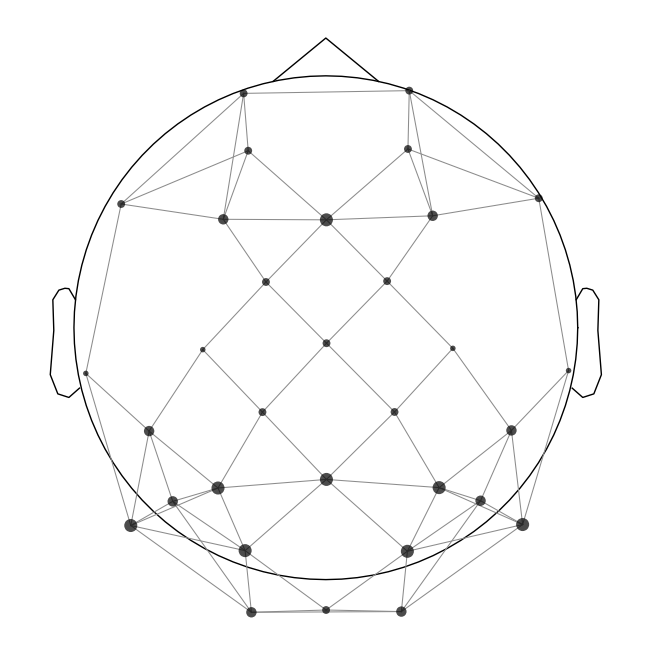

In [110]:
from scipy.sparse import csr_matrix
from scipy.spatial import distance_matrix

def compute_adjacency():
    eeg_data = np.zeros((32, 2))
    # get placement data of standard 10-20 system
    montage_1020 = mne.channels.make_standard_montage('standard_1020')
    positions_1020 = montage_1020._get_ch_pos()
    ch_names = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8',
                'FC1', 'FC2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 
                'CP2', 'CP6', 'P7', 'P5', 'P3', 'Pz', 'P4', 'P6', 'P8',
                'PO3', 'PO4', 'O1', 'Oz', 'O2']
    ch_types = ['eeg'] * 32
    info = mne.create_info(ch_names, sfreq=1200, ch_types=ch_types, verbose=False)
    raw = mne.io.RawArray(eeg_data, info, verbose=False)

    elec_coords = {ch: positions_1020[ch] for ch in ch_names}
    montage = mne.channels.make_dig_montage(elec_coords, coord_frame='head')
    raw.set_montage(montage)
    
    # Extract the 3D coordinates
    pos = np.stack([raw.info['dig'][i]['r'] for i in range(len(raw.info['dig'])) if raw.info['dig'][i]['kind'] == mne.io.constants.FIFF.FIFFV_POINT_EEG])
    
    # Calculate the distance matrix
    dist_matrix = distance_matrix(pos, pos)
    
    # Define adjacency based on distance threshold
    threshold = np.percentile(dist_matrix, 17.5)  # !!!!! 17.5th percentile of distances as threshold
    adjacency_matrix = dist_matrix < threshold
    
    return adjacency_matrix


ch_names = ['Fp1', 'Fp2', 'AF3', 'AF4', 'F7', 'F3', 'Fz', 'F4', 'F8',
                'FC1', 'FC2', 'T7', 'C3', 'Cz', 'C4', 'T8', 'CP5', 'CP1', 
                'CP2', 'CP6', 'P7', 'P5', 'P3', 'Pz', 'P4', 'P6', 'P8',
                'PO3', 'PO4', 'O1', 'Oz', 'O2']
raw = fe.channel_pos()
adjacency_ndarray = compute_adjacency()
adjacency = csr_matrix(adjacency_ndarray)
mne.viz.plot_ch_adjacency(raw.info, adjacency, ch_names)

In [111]:
def remove_bp_outliers(data, lowk, highk, verbose=False):
    condition_data = np.copy(data)  # This ensures that the original data remains unchanged
    # Step 1: Zero out outliers more than 3 IQRs from the Q1 or Q3
    counts_zeroed = np.zeros(32, dtype=int)  # To keep track of how many values are set to 0
    for i in range(condition_data.shape[1]):  # Iterate over each column
        column = condition_data[:, i]
        Q1 = np.percentile(column, 25)
        Q3 = np.percentile(column, 75)
        IQR = Q3 - Q1
        lower_bound = Q1 - lowk * IQR
        upper_bound = Q3 + highk * IQR
        
        # Zero out outliers
        outliers_mask = (column < lower_bound) | (column > upper_bound)
        counts_zeroed[i] = np.sum(outliers_mask)
        condition_data[outliers_mask, i] = 0
    if verbose:
        print('Q1:', Q1, 'Q3:', Q3, 'IQR:', IQR, 'Lower bound:', lower_bound, 'Upper bound:', upper_bound)
        print("Total numbers set to 0 per column:", counts_zeroed)
        print("Total numbers set to 0:", np.sum(counts_zeroed))

    # Step 2: Replace 0 values with the median of the non-zero values in each column
    for i in range(condition_data.shape[1]):
        column = condition_data[:, i]
        non_zero_median = np.median(column[column != 0])  # Compute median excluding zeros
        condition_data[column == 0, i] = non_zero_median  # Replace zeros with the computed median
    
    return condition_data

# condition1_original = bp_data[2][:,:,1]
# condition1 = remove_bp_outliers(condition1_original, lowk=3, highk=3, verbose=True)



Band: theta

Comparison: pre-sham vs. pre-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]

Comparison: pre-sham vs. post-sham


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8 10 11 12 13 15 16 17 18 19 20 22 24 25 26 27
 28 29 30 31]

Comparison: pre-active vs. post-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]


Band: alpha

Comparison: pre-sham vs. pre-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]

Comparison: pre-sham vs. post-sham


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 21 22 23 24
 25 26 27 28 29 30 31]

Comparison: pre-active vs. post-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]


Band: beta

Comparison: pre-sham vs. pre-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]

Comparison: pre-sham vs. post-sham


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8 10 11 12 14 15 16 17 18 19 20 21 23 24 25 26
 27 28 29 30 31]

Comparison: pre-active vs. post-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25
 26 27 28 29 30 31]


Band: gamma

Comparison: pre-sham vs. pre-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 24
 25 26 27 28 29 30 31]

Comparison: pre-sham vs. post-sham


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31]

Comparison: pre-active vs. post-active


C:\Users\Tianyi Zheng\AppData\Local\Temp\ipykernel_4340\3727797436.py:19: RuntimeWarning: Ignoring argument "tail", performing 1-tailed F-test
  f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(


Cluster 0, p-value: 0.0005
Electrodes: [ 1  2  3  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 23 24 25 26
 27 29 30 31]


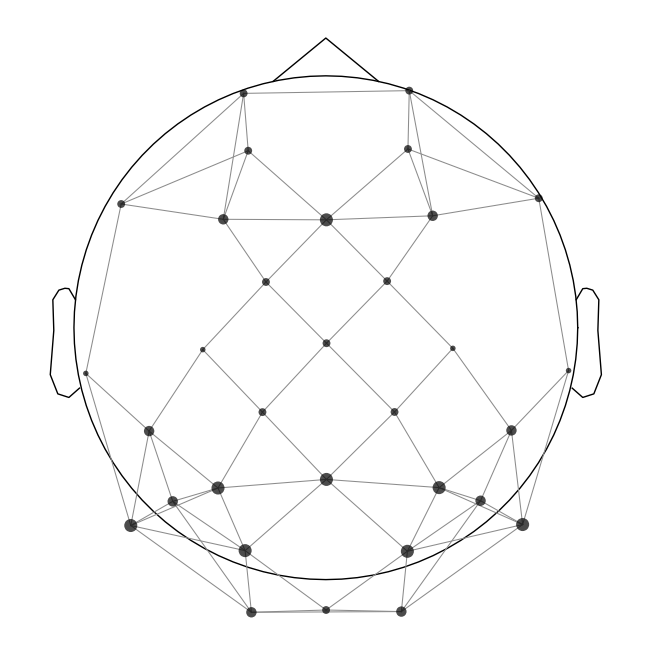

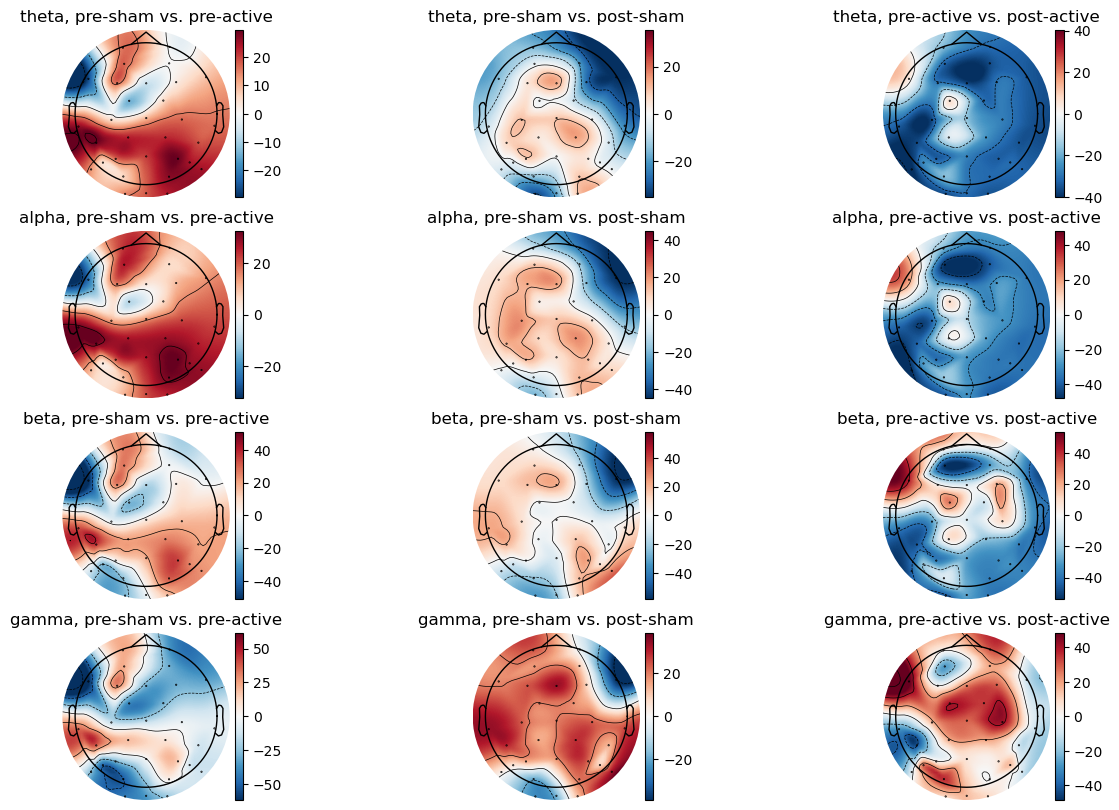

In [112]:
from mne.stats import permutation_cluster_test, permutation_cluster_1samp_test
from mpl_toolkits.axes_grid1 import make_axes_locatable

def sign_of_tvalue(condition1, condition2):
    # Step 1: Calculate median of each column for both conditions
    condition1_med = np.median(condition1, axis=0)
    condition2_med = np.median(condition2, axis=0)
    # Step 2: Subtract condition1_med from condition2_med
    subs = condition2_med - condition1_med
    # Step 3: Convert positive values to 1 and negative values to -1
    subs = np.where(subs > 0, 1, -1)
    
    return subs

def perm_test(condition1, condition2, adjacency, outlier_highk=3):
    condition1 = remove_bp_outliers(condition1, lowk=3, highk=outlier_highk, verbose=False)
    condition2 = remove_bp_outliers(condition2, lowk=3, highk=outlier_highk, verbose=False)
    # T-test
    f_obs, clusters, cluster_p_values, H0 = permutation_cluster_test(
        [condition1, condition2], n_permutations=2000, adjacency=adjacency, tail=0, verbose=False)
    # Find significant clusters
    significant_clusters = np.nonzero(cluster_p_values < 0.05)[0]

    for idx in significant_clusters:
        cluster = clusters[idx][0]
        if cluster.shape[0] > 1:
            print(f"Cluster {idx}, p-value: {cluster_p_values[idx]}")
            print("Electrodes:", cluster)
    
    sign = sign_of_tvalue(condition1, condition2)
    t_obs = np.sqrt(f_obs) * sign
    return t_obs

def normalize_t_obs(t_obs):
    # Step 1: Find the maximum absolute value
    max_abs_value = np.max(np.abs(t_obs))
    
    # Step 2: Normalize the array
    normalized_t_obs = (t_obs / max_abs_value) * 3
    
    return normalized_t_obs

band_names = ['theta', 'alpha', 'beta', 'gamma']
comparisons = [[0, 2], [0, 1], [2, 3]]
comparison_names = ['pre-sham vs. pre-active', 'pre-sham vs. post-sham', 'pre-active vs. post-active']

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(band_names), ncols=len(comparison_names), figsize=(15, 10))

for i, band_name in enumerate(band_names):
    print(f"\n\nBand: {band_name}")
    for j, comparison in enumerate(comparisons):
        condition1 = bp_data[comparison[0]][:,:,i]
        condition2 = bp_data[comparison[1]][:,:,i]
        print(f"\nComparison: {comparison_names[j]}")
        t_obs = perm_test(condition1, condition2, adjacency, outlier_highk=1.5)
        # t_obs[4] = 0
        
        ax = axes[i, j]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(t_obs, pos=raw.info, axes=ax, show=False, contours=5)
        # Add title to each subplot
        ax.set_title(band_name + ', ' + comparison_names[j])
        # Add colorbar
        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
plt.show()

In [113]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

bp_subtracts = np.zeros((2, 32, 4))
bp_subtracts_norm = np.zeros((2, 32, 4))
bp_subtracts[0,:,:] = bp_table[1,:,:] - bp_table[0,:,:]
bp_subtracts[1,:,:] = bp_table[3,:,:] - bp_table[2,:,:]
bp_subtracts_norm[0,:,:] = bp_subtracts[0,:,:] / bp_table[0,:,:]
bp_subtracts_norm[1,:,:] = bp_subtracts[1,:,:] / bp_table[2,:,:]

raw = fe.channel_pos()

band_names = ['$\u03B8$', '$\u03B1$', '$\u03B2$', '$\u03B3$']
group_names = ['sham', 'real']

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = [(-5e-8, 5e-8), (-3e-8, 3e-8), (-3e-8, 3e-8), (-1.5e-8, 1.5e-8)]

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim[k])
        # Add title to each subplot
        # ax.set_title(group_name + ' ' + band_name)

        # Create an axis for the color bar
        divider = make_axes_locatable(ax)
        cax = divider.append_axes('right', size='5%', pad=0.05)
        
        # Add the color bar to the current subplot
        cbar = plt.colorbar(im, cax=cax, orientation='vertical')
        cbar.set_ticks([cbar_lim[k][0], 0, cbar_lim[k][1]])


# fig.suptitle(case_title, fontsize=20, y=1.08)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.89, top=0.94)
plt.subplots_adjust(wspace=0.3)
# plt.tight_layout()
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure 4', case_title+'_topos.eps')
plt.savefig(save_path, format='eps')
plt.show()

cm = 1/2.54
fig, axes = plt.subplots(nrows=len(group_names), ncols=len(band_names), figsize=(9.4*cm, 5*cm))
cbar_lim = (-1, 1)

for k, band_name in enumerate(band_names):
    for i, group_name in enumerate(group_names):
        ax = axes[i, k]  # Get the correct axis from the grid
        im, cn = mne.viz.plot_topomap(bp_subtracts_norm[i,:,k], pos=raw.info, axes=ax, show=False, contours=0, vlim=cbar_lim)
        # Add title to each subplot
        ax.set_title(group_name + ' ' + band_name)

# Add a colorbar to the right of the subplots grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical')
cbar.set_ticks([-1, 0, 1])
cbar.set_ticklabels(['-100%', '0%', '100%'])
cbar.set_label('% power change')
# fig.suptitle(case_title + ', by %', fontsize=20, y=1.1)
matplotlib.rcParams.update({'font.size': 7})
fig.subplots_adjust(left=0.01, bottom=0.01, right=0.88, top=0.94)
save_path = os.path.join('..', '..', '..', '..', 'paper', 'Figure S3', case_title+'_topos_norm.eps')
# plt.savefig(save_path, format='eps')
plt.show()

NameError: name 'bp_table' is not defined